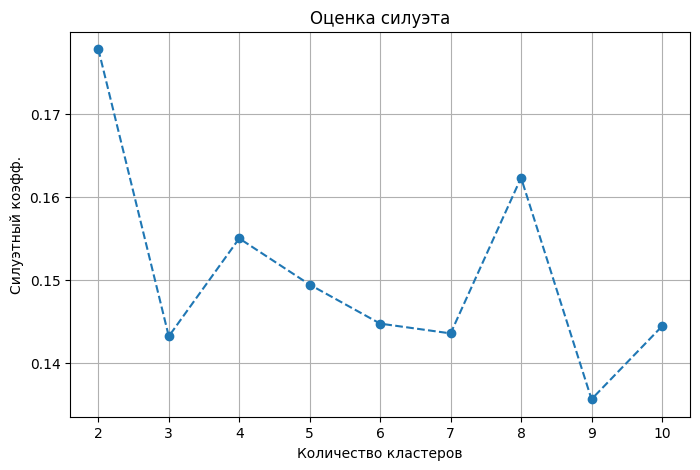

Оптимальное количество кластеров: 2, Макс. силуэт: 0.178


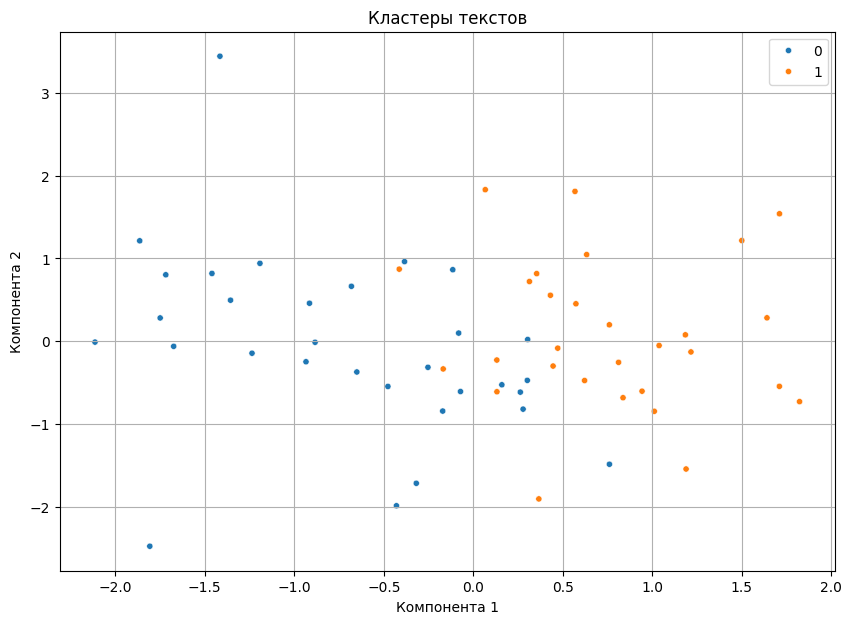

In [6]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def run(folder_path, top_n=100, max_k=10):

    def load_texts(folder_path):
      """Загружает тексты из указанной папки"""
      texts = []
      filenames = []
      for filename in os.listdir(folder_path):
          if filename.endswith(".txt"):
              with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                  texts.append(file.read())
                  filenames.append(filename)
      return texts, filenames

    texts, filenames = load_texts(folder_path)

    def clean_text(text):
      """Очищает текст от пунктуации и приводит к нижнему регистру"""
      text = re.sub(r'[^a-zA-Z\s]', '', text)
      return text.lower().split()

    def get_top_words(texts, top_n=100):
      """Возвращает список наиболее частых слов"""
      word_counts = Counter()
      for text in texts:
          word_counts.update(clean_text(text))
      top_words = [word for word, _ in word_counts.most_common(top_n)]
      return top_words

    top_words = get_top_words(texts, top_n)

    def build_frequency_matrix(texts, top_words):
      """Строит матрицу частот для топовых слов"""
      matrix = []
      for text in texts:
          word_counts = Counter(clean_text(text))
          matrix.append([word_counts.get(word, 0) for word in top_words])

      frequency_matrix = np.array(matrix)
      return frequency_matrix

    frequency_matrix = build_frequency_matrix(texts, top_words)

    def normalize_frequencies(frequency_matrix):
      """Нормализует частотную матрицу с помощью TF-IDF"""
      transformer = TfidfTransformer()
      normalized_matrix = transformer.fit_transform(frequency_matrix).toarray()
      return normalized_matrix

    normalized_matrix = normalize_frequencies(frequency_matrix)

    def find_optimal_clusters(normalized_matrix, max_k=10):
      """Находит оптимальное количество кластеров по силуэтному коэффициенту"""
      best_k = 2
      best_score = -1
      scores = []

      for k in range(2, max_k + 1):
          model = KMeans(n_clusters=k, random_state=42)
          labels = model.fit_predict(normalized_matrix)
          score = silhouette_score(normalized_matrix, labels)
          scores.append((k, score))

          if score > best_score:
              best_k = k
              best_score = score

      """Визуализация зависимости силуэта от количества кластеров"""
      visualize_silhouette_score(scores)

      print(f"Оптимальное количество кластеров: {best_k}, Макс. силуэт: {best_score:.3f}")
      return best_k

    def visualize_silhouette_score(scores):
      """Визуализирует силуэтный коэффициент в зависимости от количества кластеров"""
      plt.figure(figsize=(8, 5))
      plt.plot([k for k, _ in scores], [score for _, score in scores], marker='o', linestyle='--')
      plt.title("Оценка силуэта")
      plt.xlabel("Количество кластеров")
      plt.ylabel("Силуэтный коэфф.")
      plt.grid()
      plt.show()

    optimal_k = find_optimal_clusters(normalized_matrix, max_k)

    def cluster_texts(normalized_matrix, n_clusters):
      """Выполняет кластеризацию текстов с заданным количеством кластеров"""
      model = KMeans(n_clusters=n_clusters, random_state=42)
      labels = model.fit_predict(normalized_matrix)
      return labels

    labels = cluster_texts(normalized_matrix, optimal_k)

    def visualize_clusters(normalized_matrix, labels):
      """Визуализирует кластеры на 2D плоскости"""
      scaler = StandardScaler()
      scaled_matrix = scaler.fit_transform(normalized_matrix)
      plt.figure(figsize=(10, 7))
      sns.scatterplot(x=scaled_matrix[:, 0], y=scaled_matrix[:, 1], hue=labels, palette="tab10", s=20)
      plt.title("Кластеры текстов")
      plt.xlabel("Компонента 1")
      plt.ylabel("Компонента 2")
      plt.grid()
      plt.show()

    visualize_clusters(normalized_matrix, labels)

    return normalized_matrix, labels, filenames

folder_path = r"/content"
normalized_matrix, labels, filenames = run(folder_path, top_n=100, max_k=10)